In [1]:
import json

import bz2
from tqdm import tqdm_notebook
from scipy import sparse
import re

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File(r'C:\Users\astashkin.p.SLV\Desktop\data\banki_responses.json.bz2', 'r') as thefile:
    i = 0
    for row in tqdm_notebook(thefile):
        if i % 5 == 0:
            resp = json.loads(row)
            if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
                responses.append(resp)
        i += 1

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Одинцово',
 'rating_not_checked': False,
 'title': 'Благодарность за обслуживание',
 'num_comments': 3,
 'bank_license': 'лицензия № 1623',
 'author': 'ЯВИ',
 'bank_name': 'ВТБ 24',
 'datetime': '2015-06-01 16:55:09',
 'text': 'Добрый день, уважаемые руководители! Мне нравится банк ВТБ 24. Радует, что всё\xa0настолько скрупулёзно, такая степень защиты моих финансовых секретов, что диву даёшься. А ещё здесь работают профессионалы, которые внимательно относятся к собеседнику.  Благодарен тому, что в минуту поиска вариантов оплаты за коммунальные услуги, которые устроили бы меня, как пенсионера, встретился с одним из таких специалистов. Он настолько по-доброму отнёсся к моим вопросам, так быстро "разгрёб эту кучу", что я стал\xa0 клиентом Телебанка. Без особых хлопот теперь провожу оплату всего за 0,6%. Мне это очень выгодно.  Ваш сотрудник настолько покорил своими качествами, что как-то разом пришли вот такие строки: Есть на свете ВТБ, Банк, не знающим сие. И работает в нём 

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

1. Смотрим распределение отзывов по городам и банкакм. Посмотрим на гистограммы рейтингов и их распределения по городам и банкам. Но сперва собирем датасет.

In [5]:
df = pd.DataFrame(responses)

In [6]:
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
2,Юля2015,лицензия № 1326,Альфа-Банк,г. Москва,2015-06-05 12:24:28,15,NaN,False,"Вот даже и засомневалась, какую ставить оценку...",Повесили кредит
3,r1man,лицензия № 1326,Альфа-Банк,г. Санкт-Петербург,2015-06-05 13:11:29,0,NaN,False,"Без оценки, т.к. несколько лет отличной работы...",Стечение обстоятельств
4,dubrowki,лицензия № 3349,Россельхозбанк,г. Конаково,2015-06-05 14:32:06,0,NaN,False,Хочется высказать по поводу режима работы банк...,Режим работы только для неработающих


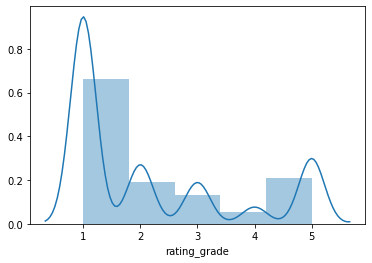

In [7]:
#Распределение рейтингов по отзывам. Без рейтинга исключены.
sns.distplot(df.rating_grade.dropna(), bins=5)
plt.show()

Ожидаемо много негатива. Стоит задуматься о балансировке классов. Посмотрим на данные по городам и банкам

In [8]:
df.bank_name.unique()[:20]

array(['Бинбанк', 'Сбербанк России', 'Альфа-Банк', 'Россельхозбанк',
       'ВТБ 24', 'Лето Банк', 'Петрокоммерц', 'Татфондбанк',
       'Тинькофф Банк', 'Уральский Банк Реконструкции и Развития',
       'Русский Стандарт', 'Хоум Кредит Банк', 'Военно-Промышленный Банк',
       'Ханты-Мансийский банк Открытие', 'Восточный Экспресс Банк',
       'Ренессанс Кредит', 'Югра', 'ЮниКредит Банк',
       'Национальный Банк «Траст»', 'РосинтерБанк'], dtype=object)

In [9]:
df.city.sort_values().unique()[:20]

array(['г.  (Москва)', 'г.  (Ханты-Мансийский автономный округ)', 'г. -',
       'г. 140051, МО, Люберецкий район, Красково',
       'г. 143420 Московская область, Красногорский район, посёлок дачного хозяйства Архангельское, д.4,кв.2',
       'г. 2-я Гавриловка', 'г. :erjdcrbq (Москва)',
       'г. ? видимо москва или новосибирск', 'г. Bremen (Москва)',
       'г. Cанкт -Петербург', 'г. Cанкт-Петербург',
       'г. Cанкт-Петербург (Ленинский пр)', 'г. Cаранск', 'г. Djkujuhfl',
       'г. Khimki', 'г. MSK', 'г. Miami Beach', 'г. Moscow', 'г. Moskva',
       'г. Naberezhnye Chelny'], dtype=object)

Как видим, наименования банков выбирались из списков, а город указывался пользователем. Визулизируем распределение отзывов по банкам.

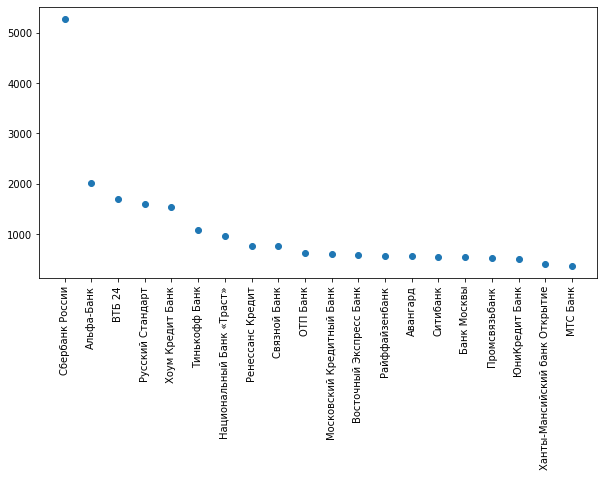

In [10]:
plt.figure(figsize=(10,5))
plt.plot(df.groupby(by='bank_name').count().sort_values(by='text', ascending=False)['text'][:20], 'o')
plt.xticks(rotation=90)
plt.show()

In [11]:
city_plot = df.copy()
city_plot = city_plot.fillna('Прочее')

In [12]:
city_plot['city_clear'] = city_plot.apply(lambda x: x.city.lower(), axis=1)

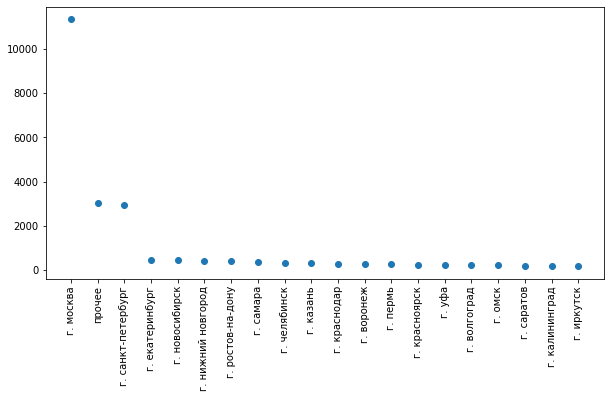

In [13]:
plt.figure(figsize=(10,5))
plt.plot(city_plot.groupby(by='city_clear').count().sort_values(by='text', ascending=False)['text'][:20], 'o')
plt.xticks(rotation=90)
plt.show()

Видим, что распределение отзывов сопоставимо с численностью населения в регионе. Также присутствует большое количество отзывов без указания адреса. Судя по всему, в поле адрес реализованы подсказки, но нет списочных значений и пользователь может указать что хочет.

2. Строим гистограммы распределения слов в отзывах и символов в словах

In [14]:
regex = re.compile('[А-Яа-яЁё]+')
df_low_text = df.text.str.lower()
df_low_text = df_low_text.apply(lambda x: regex.findall(x))

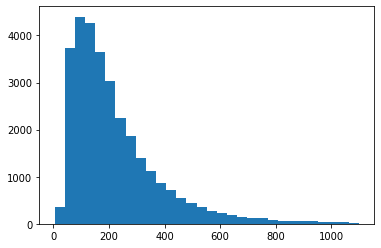

In [15]:
#Слова в отзыве
plt.hist(df_low_text.apply(len)[df_low_text.apply(len) <= 1100], bins = 30)
plt.show()

In [16]:
#Слов в медианном отзыве
df_low_text.apply(len)[df_low_text.apply(len) <= 1100].median()

175.0

In [17]:
# Собираем все слова с повторениями
all_words_list = []
for words in df_low_text:
    for word in words:
        all_words_list.append(word)

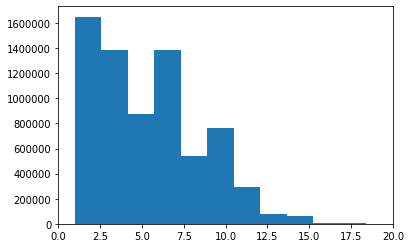

In [18]:
# Распределение длин слов с повторениями
plt.hist(list(map(len, all_words_list)), bins=50)
plt.xlim(0, 20)
plt.show()

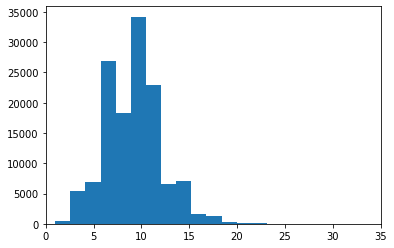

In [19]:
# Распределение длин слов без повторений
plt.hist(list(map(len, set(all_words_list))), bins=50)
plt.xlim(0, 35)
plt.show()

In [20]:
from collections import Counter
cntr = Counter()

cntr.update(all_words_list)

3. Найдем самые популярные слова до применения стопслов

In [21]:
cntr.most_common(10)

[('в', 265326),
 ('и', 211553),
 ('не', 170613),
 ('на', 140863),
 ('что', 127213),
 ('я', 114788),
 ('с', 92192),
 ('по', 74316),
 ('мне', 63556),
 ('банка', 55017)]

Исключим стоп-слова и снова посмотрим на топ.

In [22]:
from nltk.corpus import stopwords

# Добавим названия банков в список стоп-слов
all_banks = df.bank_name.unique().tolist()
mystopwords = set(stopwords.words('russian') + \
                  ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', 'г', 'т', 'д', 'банк', 'банку', 'банком', 'банка', 'банке'] + \
                  list(map(lambda x: x.lower(), all_banks)))

all_words_wo_stopword_list = []

for token in tqdm_notebook(all_words_list):
    if token not in mystopwords:
        all_words_wo_stopword_list.append(token)

In [23]:
cntr_stwrds = Counter()
cntr_stwrds.update(all_words_wo_stopword_list)
cntr_stwrds.most_common(10)

[('деньги', 26211),
 ('карту', 20941),
 ('карты', 20015),
 ('кредит', 16089),
 ('день', 15390),
 ('заявление', 13977),
 ('очень', 13483),
 ('время', 13356),
 ('отделение', 13218),
 ('счет', 11400)]

Лемматизируем наш корупус и оценим топ лемм без стоп-слов и стоп-лемм

In [24]:
from pymorphy2 import MorphAnalyzer

pm2 = MorphAnalyzer()

In [25]:
def text_beautifier(text, rule = '[А-Яа-яЁё]+'):
    regex = re.compile(rule)
    text = text.lower()
    text = regex.findall(text)
    text = ' '.join(text)
    return text

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def lemmatize(text, pm2=pm2):
    try:
        lemmas = [pm2.parse(word)[0].normal_form for word in text.split()]
        return ' '.join(lemmas)
    except:
        return " "
    
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'банк', 'зао', 'ооо', 'оао', 'пао', 'рубль'] + list(map(lambda x: x.lower(), all_banks))
def remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [26]:
df['lemma'] = df.apply(lambda x: text_beautifier(x.text, '[А-Яа-яЁё]+'), axis=1)
df['lemma'] = df.apply(lambda x: remove_stopwords(x.lemma, mystopwords), axis=1)
df['lemma'] = df['lemma'].apply(lemmatize)
df['lemma'] = df['lemma'].apply(remove_stoplemmas)

In [27]:
df_lemmas = df.lemma.tolist()

In [28]:
all_lemmas_list = []
for words in df_lemmas:
    words = words.split(' ')
    for word in words:
        all_lemmas_list.append(word)

In [29]:
cntr_lemmas = Counter()
cntr_lemmas.update(all_lemmas_list)
cntr_lemmas.most_common(10)

[('карта', 66369),
 ('деньга', 35853),
 ('день', 34048),
 ('мой', 31837),
 ('кредит', 31267),
 ('отделение', 28764),
 ('счёт', 28304),
 ('клиент', 27347),
 ('сотрудник', 26856),
 ('сказать', 23119)]

Найдем все существительные и построим топ

In [30]:
all_nouns_list = []
for lemma in tqdm_notebook(all_lemmas_list):
    if 'NOUN' in pm2.parse(lemma)[0].tag:
        all_nouns_list.append(lemma)

In [31]:
cntr_nouns = Counter()
cntr_nouns.update(all_nouns_list)
cntr_nouns.most_common(10)

[('карта', 66369),
 ('деньга', 35853),
 ('день', 34048),
 ('кредит', 31267),
 ('отделение', 28764),
 ('счёт', 28304),
 ('клиент', 27347),
 ('сотрудник', 26856),
 ('сумма', 22565),
 ('год', 20811)]

4. Закон Ципфа

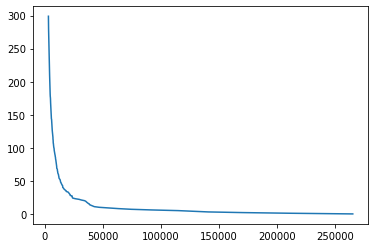

In [32]:
freqs = list(cntr.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

Закон Хипса

In [33]:
n_tokens = []
n_types = []
types = set()

for word, words in zip(all_words_list, range(len(all_words_list))):
    n_tokens.append(words)
    types.add(word)
    n_types.append(len(types))    

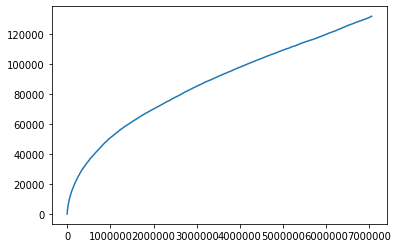

In [34]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

5. Отвечаем на вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [35]:
print('Слово "сотрудник" встречается ' + str(cntr_lemmas['сотрудник']) + \
      ', а слово "клиент" ' + str(cntr_lemmas['клиент']) + '. \nВыходит, "клиент" встречается чаще, если мы говорим о леммах слов.')

Слово "сотрудник" встречается 26856, а слово "клиент" 27347. 
Выходит, "клиент" встречается чаще, если мы говорим о леммах слов.


In [36]:
print('Слово "мошенничество" встречается ' + str(cntr_lemmas['мошенничество']) + \
      ', а слово "доверие" ' + str(cntr_lemmas['доверие']))

Слово "мошенничество" встречается 593, а слово "доверие" 433


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Воспользуемся мерой $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [38]:
corpus_checked = df[~df['rating_not_checked']]
corpus_lemmas = corpus_checked.lemma.tolist()
positive_ids = corpus_checked[corpus_checked['rating_grade'] == 5].index.tolist()
negative_ids = corpus_checked[corpus_checked['rating_grade'] == 1].index.tolist()

In [39]:
tfidf_matrix = vectorizer.fit_transform(corpus_lemmas)

In [40]:
features = vectorizer.get_feature_names()

In [41]:
positive = []
negative = []
for row in tqdm_notebook(range(tfidf_matrix.shape[0])):
    if row in positive_ids:
        positive.append(tfidf_matrix[row])
    if row in negative_ids:
        negative.append(tfidf_matrix[row])

In [42]:
pos_keywrds = np.zeros_like(positive[0].toarray()[0])
for each in tqdm_notebook(positive):
    pos_keywrds += each.toarray()[0]

In [43]:
neg_keywrds = np.zeros_like(negative[0].toarray()[0])
for each in tqdm_notebook(negative):
    neg_keywrds += each.toarray()[0]

In [44]:
feedbacks = pd.DataFrame(np.array((np.array(features), pos_keywrds, neg_keywrds)).T, columns=['key_words', 'tfidf_positive', 'tfidf_negative'])

In [45]:
feedbacks['n_gramm'] = feedbacks.apply(lambda x: len(x.key_words.split()), axis=1)

In [46]:
print('Ключевые слова для положительных отзывов:')
print(feedbacks.sort_values(by='tfidf_positive', ascending=False)[feedbacks['n_gramm'] == 1].key_words[:10].tolist(), '\n')
print('Биграмы для положительных отзывов:')
print(feedbacks.sort_values(by='tfidf_positive', ascending=False)[feedbacks['n_gramm'] == 2].key_words[:10].tolist(), '\n')
print('Ключевые слова для отрицательных отзывов:')
print(feedbacks.sort_values(by='tfidf_negative', ascending=False)[feedbacks['n_gramm'] == 1].key_words[:10].tolist(), '\n')
print('Биграмы для отрицательных отзывов:')
print(feedbacks.sort_values(by='tfidf_negative', ascending=False)[feedbacks['n_gramm'] == 2].key_words[:10].tolist(), '\n')

Ключевые слова для положительных отзывов:
['место', 'сам', 'справка', 'звонить', 'отличный', 'это', 'оценка', 'анкета', 'бывать', 'подробно'] 

Биграмы для положительных отзывов:
['следующий день', 'хотеть выразить', 'являться клиент', 'очень быстро', 'открыть вклад', 'огромный спасибо', 'выразить благодарность', 'большой спасибо', 'пользоваться услуга', 'очень вежливый'] 

Ключевые слова для отрицательных отзывов:
['ответ', 'вклад', 'год', 'вопрос', 'дать', 'офис', 'получить', 'договор', 'время', 'номер'] 

Биграмы для отрицательных отзывов:
['положить деньга', 'новый карта', 'просрочить задолженность', 'звонить горячий', 'процентный ставка', 'электронный почта', 'почему должный', 'ближний время', 'мой вопрос', 'какой отделение'] 



Любопытно получилось. Полученные результаты полностью подтверждают мой прошлый опыт работы в банке: в основном жалуйстся те, кто забыл или невнимательно читал условия договоров или ушел в дефолт. Что еще интресно: негативные биграмы также встречаются в положительных отзывах, однако их tfidf скор в 10 раз меньше.

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [47]:
from gensim.corpora import Dictionary
from gensim.models import  *

In [48]:
dataset = [corpus_lemmas[i].split() for i in range(len(corpus_lemmas))]
dct = Dictionary(dataset)

In [49]:
corpus = [dct.doc2bow(line) for line in dataset]
model = TfidfModel(corpus)
vector = model[corpus]

In [50]:
lsi = lsimodel.LsiModel(corpus=corpus, id2word=dct, num_topics=5)
lsi.show_topics()

[(0,
  '0.466*"карта" + 0.198*"мой" + 0.190*"деньга" + 0.185*"день" + 0.175*"счёт" + 0.164*"отделение" + 0.154*"кредит" + 0.153*"клиент" + 0.151*"сотрудник" + 0.133*"сказать"'),
 (1,
  '-0.798*"карта" + 0.347*"кредит" + 0.137*"сумма" + 0.137*"договор" + 0.121*"сотрудник" + 0.115*"платёж" + 0.097*"день" + 0.089*"клиент" + 0.080*"документ" + 0.078*"мой"'),
 (2,
  '-0.506*"кредит" + 0.468*"деньга" + 0.311*"счёт" + -0.238*"карта" + 0.236*"вклад" + -0.228*"кредитный" + 0.203*"банкомат" + 0.103*"операция" + 0.101*"отделение" + -0.101*"договор"'),
 (3,
  '-0.412*"счёт" + -0.293*"сумма" + -0.249*"деньга" + 0.222*"отделение" + -0.210*"кредит" + 0.188*"клиент" + -0.181*"средство" + -0.176*"платёж" + 0.175*"сотрудник" + 0.175*"вклад"'),
 (4,
  '0.348*"мой" + -0.301*"кредит" + 0.252*"заявление" + 0.247*"номер" + -0.243*"вклад" + -0.227*"деньга" + 0.189*"дать" + 0.185*"средство" + 0.169*"сбербанк" + 0.162*"сотрудник"')]

Примечательно, что по коэффициентам при словах можно разделить темы на разные виды банковских операций. Например второй топик про проблемы с размещением денег на вкладе, а топик с номером 5(счет от 1), про получение кредита.

Также удалось найти среди ключевых слов название банка (5 топик). Это странно, ведь я добавил названия банков в стоп слова, т.к. они не очень характеризуют эмоциональный окрас текста. Как мне кажется, лемматизатор воспринимает названия банков как имена собственные.

Сейчас попробую извлечь темы только из негативных отзывов. Надеюсь получится разделить отзывы чуть точнее.

In [51]:
neg_lemmas = []
for i  in range(len(corpus_lemmas)):
    if i in negative_ids:
        neg_lemmas.append(corpus_lemmas[i])

In [52]:
dataset_neg = [neg_lemmas[i].split() for i in range(len(neg_lemmas))]
dct_neg = Dictionary(dataset_neg)

In [53]:
corpus_neg = [dct_neg.doc2bow(line) for line in dataset_neg]
model_neg = TfidfModel(corpus_neg)
vector_neg = model_neg[corpus_neg]

In [54]:
lsi_neg = lsimodel.LsiModel(corpus=corpus_neg, id2word=dct_neg, num_topics=5)
lsi_neg.show_topics()

[(0,
  '0.432*"карта" + 0.200*"мой" + 0.194*"день" + 0.191*"деньга" + 0.189*"отделение" + 0.175*"счёт" + 0.168*"сотрудник" + 0.153*"кредит" + 0.152*"заявление" + 0.150*"клиент"'),
 (1,
  '-0.816*"карта" + 0.324*"кредит" + 0.163*"сумма" + 0.133*"договор" + 0.130*"платёж" + 0.096*"сотрудник" + 0.087*"клиент" + 0.084*"день" + 0.079*"документ" + 0.070*"деньга"'),
 (2,
  '0.518*"деньга" + -0.478*"кредит" + 0.346*"счёт" + 0.211*"банкомат" + -0.207*"карта" + -0.194*"кредитный" + 0.145*"вклад" + 0.116*"средство" + 0.109*"сбербанк" + -0.105*"договор"'),
 (3,
  '0.410*"счёт" + 0.289*"сумма" + -0.241*"отделение" + 0.235*"кредит" + -0.182*"клиент" + 0.170*"платёж" + 0.168*"заявление" + 0.148*"деньга" + 0.148*"средство" + 0.147*"карта"'),
 (4,
  '-0.472*"деньга" + -0.318*"кредит" + 0.248*"заявление" + 0.232*"мой" + 0.229*"сотрудник" + 0.192*"средство" + -0.178*"сказать" + -0.159*"банкомат" + 0.148*"сбербанк" + 0.141*"денежный"')]

Мало что поменялось. Попробуем с положительными отзывами.

In [55]:
pos_lemmas = []
for i  in range(len(corpus_lemmas)):
    if i in positive_ids:
        pos_lemmas.append(corpus_lemmas[i])

In [56]:
dataset_pos = [pos_lemmas[i].split() for i in range(len(pos_lemmas))]
dct_pos = Dictionary(dataset_pos)

In [57]:
corpus_pos = [dct_pos.doc2bow(line) for line in dataset_pos]
model_pos = TfidfModel(corpus_pos)
vector_pos = model_pos[corpus_pos]

In [58]:
lsi_pos = lsimodel.LsiModel(corpus=corpus_pos, id2word=dct_pos, num_topics=5)
lsi_pos.show_topics()

[(0,
  '0.422*"карта" + 0.195*"очень" + 0.176*"день" + 0.169*"клиент" + 0.165*"деньга" + 0.164*"кредит" + 0.161*"мой" + 0.158*"отделение" + 0.143*"год" + 0.139*"сотрудник"'),
 (1,
  '0.760*"карта" + -0.347*"кредит" + -0.142*"документ" + -0.116*"сотрудник" + -0.116*"вклад" + -0.112*"отделение" + -0.109*"очень" + -0.096*"день" + 0.089*"лимит" + 0.088*"интернет"'),
 (2,
  '-0.565*"вклад" + 0.559*"кредит" + 0.160*"карта" + 0.153*"кредитный" + -0.142*"клиент" + 0.139*"документ" + -0.129*"счёт" + -0.128*"офис" + 0.122*"день" + -0.114*"отделение"'),
 (3,
  '-0.440*"вклад" + -0.351*"деньга" + 0.316*"сотрудник" + 0.302*"отделение" + 0.277*"клиент" + -0.223*"кредит" + -0.202*"сумма" + -0.162*"процент" + 0.147*"работа" + 0.127*"вопрос"'),
 (4,
  '0.448*"деньга" + -0.405*"вклад" + 0.376*"счёт" + -0.228*"карта" + -0.215*"очень" + -0.211*"кредит" + 0.165*"банкомат" + 0.154*"мой" + 0.126*"день" + -0.115*"кредитный"')]

Интересно. В 2х темах есть наречие очень. Клиент очень доволен, видимо. Также темы разделились по типам банковких операций на размещение вкладом и выдачу кредитов. Также в позитивных топиках отмечаются сотруденики и отделения банка.

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
    * 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
    * 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics import accuracy_score, f1_score

In [60]:
neg_samples = negative_ids[:len(positive_ids)]
pos_sapmles = positive_ids
print('negative: ', len(neg_samples), '\npositive: ', len(pos_sapmles))

negative:  2970 
positive:  2970


In [61]:
neg_corpus = []
pos_corpus = []

for i in range(len(corpus_lemmas)):
    if i in neg_samples:
        neg_corpus.append([corpus_lemmas[i], 0])
    if i in pos_sapmles:
        pos_corpus.append([corpus_lemmas[i], 1])

In [62]:
data = np.array(neg_corpus + pos_corpus).T

In [63]:
X_train, X_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.30, random_state=42)

In [64]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=30, random_state=42)), 
    ('clf', RandomForestClassifier(random_state=42))
])

1. Baseline(униграмы)

In [65]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [66]:
print('Test score\n\tacc:\t', round(accuracy_score(y_test, clf.predict(X_test)), 3), \
      '\n\tf1:\t', round(f1_score(y_test, clf.predict(X_test), pos_label='1'), 3))

Test score
	acc:	 0.855 
	f1:	 0.843


2. Биграмы

In [67]:
clf_bi = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(2,2))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=30, random_state=42)), 
    ('clf', RandomForestClassifier(random_state=42))
])

In [68]:
clf_bi.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(2, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [69]:
print('Test score\n\tacc:\t', round(accuracy_score(y_test, clf_bi.predict(X_test)), 3), \
      '\n\tf1:\t', round(f1_score(y_test, clf_bi.predict(X_test), pos_label='1'), 3))

Test score
	acc:	 0.845 
	f1:	 0.835


3. Триграмы

In [70]:
clf_tri = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(3,3))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=30, random_state=42)), 
    ('clf', RandomForestClassifier(random_state=42))
])

In [71]:
clf_tri.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(3, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [72]:
print('Test score\n\tacc:\t', round(accuracy_score(y_test, clf_tri.predict(X_test)), 3), \
      '\n\tf1:\t', round(f1_score(y_test, clf_tri.predict(X_test), pos_label='1'), 3))

Test score
	acc:	 0.55 
	f1:	 0.613


4. Символьные n-грамы

In [73]:
clf_n = Pipeline([ 
    ('vect', CountVectorizer(analyzer='char', ngram_range=(2,10))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=30, random_state=42)), 
    ('clf', RandomForestClassifier(random_state=42))
])

In [74]:
clf_n.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(2, 10), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=No...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [75]:
print('Test score\n\tacc:\t', round(accuracy_score(y_test, clf_n.predict(X_test)), 3), \
      '\n\tf1:\t', round(f1_score(y_test, clf_n.predict(X_test), pos_label='1'), 3))

Test score
	acc:	 0.861 
	f1:	 0.852


Похоже, что использование символьных n-грамов дает лучший результат. Также пришлось подкрутьтить количество скрытых представлений при снижении размерности. Выбрал 30 - интуитивно.

In [87]:
clf_n_LDA = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('lda', LatentDirichletAllocation(random_state=42)), 
    ('clf', RandomForestClassifier(random_state=42))
])

In [88]:
clf_n_LDA.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [89]:
print('Test score\n\tacc:\t', round(accuracy_score(y_test, clf_n_LDA.predict(X_test)), 3), \
      '\n\tf1:\t', round(f1_score(y_test, clf_n_LDA.predict(X_test), pos_label='1'), 3))

Test score
	acc:	 0.584 
	f1:	 0.556


Да, LDA работает крайне плохо, какие параметры я бы ни подбирал.